In [19]:
### importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

import xgboost as xgb

from sklearn.metrics import mean_squared_error as MSE


from pathlib import Path

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn

color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

In [20]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df.shape

(1462, 5)

In [21]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [22]:
print('Date Range  {} : {}'.format(df['date'].min(),df['date'].max()))

Date Range  2013-01-01 : 2017-01-01


In [23]:
df['year']=pd.to_datetime(df['date'],utc=True)



In [24]:
##month in numeric
df['month']=pd.to_datetime(df['date'],utc=True)


In [25]:
## Month Name
df['Month Name']=pd.to_datetime(df['date'],utc=True)


In [26]:
df['Day Name']=pd.to_datetime(df['date'],utc=True)


In [27]:
## Feature to identify Weekday and Weekend
df['Day of week']=['Weekend' if i in (['Saturday','Sunday']) else 'Weekday' for i in df['Day Name'] ]

In [28]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month,Month Name,Day Name,Day of week
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,2013-01-01 00:00:00+00:00,Weekday
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013-01-02 00:00:00+00:00,2013-01-02 00:00:00+00:00,2013-01-02 00:00:00+00:00,2013-01-02 00:00:00+00:00,Weekday
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013-01-03 00:00:00+00:00,2013-01-03 00:00:00+00:00,2013-01-03 00:00:00+00:00,2013-01-03 00:00:00+00:00,Weekday
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013-01-04 00:00:00+00:00,2013-01-04 00:00:00+00:00,2013-01-04 00:00:00+00:00,2013-01-04 00:00:00+00:00,Weekday
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013-01-05 00:00:00+00:00,2013-01-05 00:00:00+00:00,2013-01-05 00:00:00+00:00,2013-01-05 00:00:00+00:00,Weekday


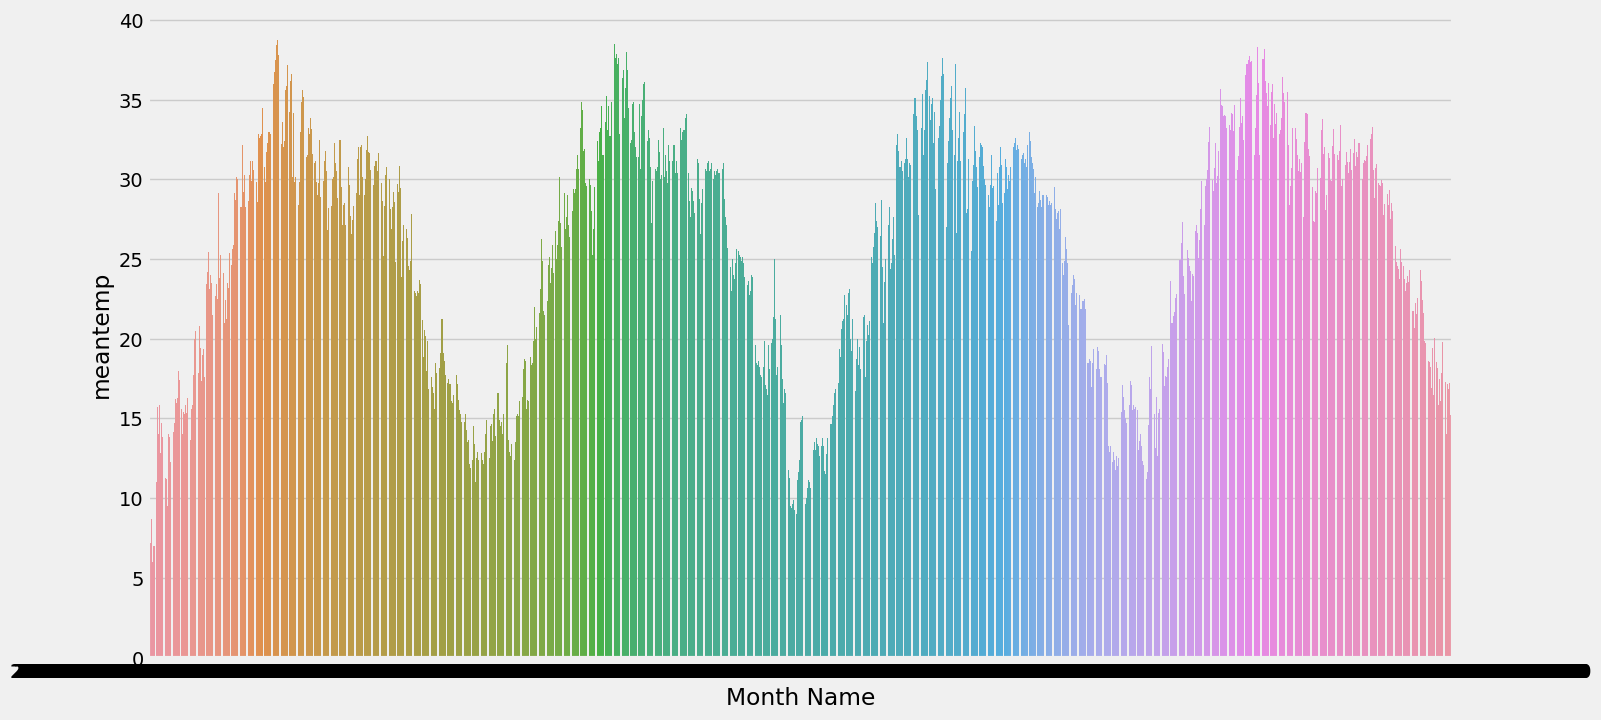

In [29]:
gb=df.groupby(['month','Month Name'])['meantemp'].mean().reset_index()
plt.figure(figsize=(15,8))
sns.barplot(x='Month Name',y='meantemp',data=gb);

In [30]:
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 15

In [31]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [32]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [33]:
df = pd.concat((df_test, df_train), ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'])

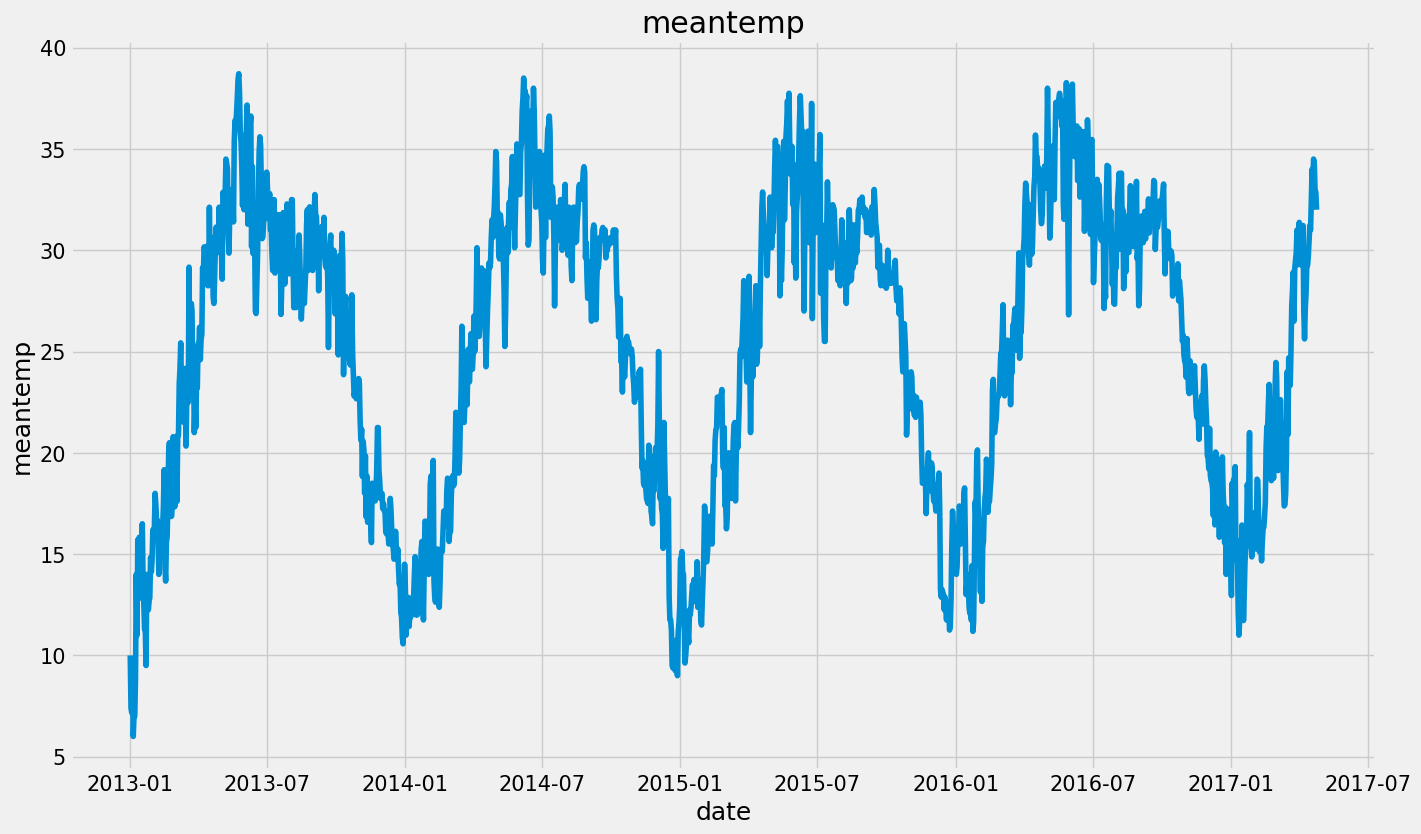

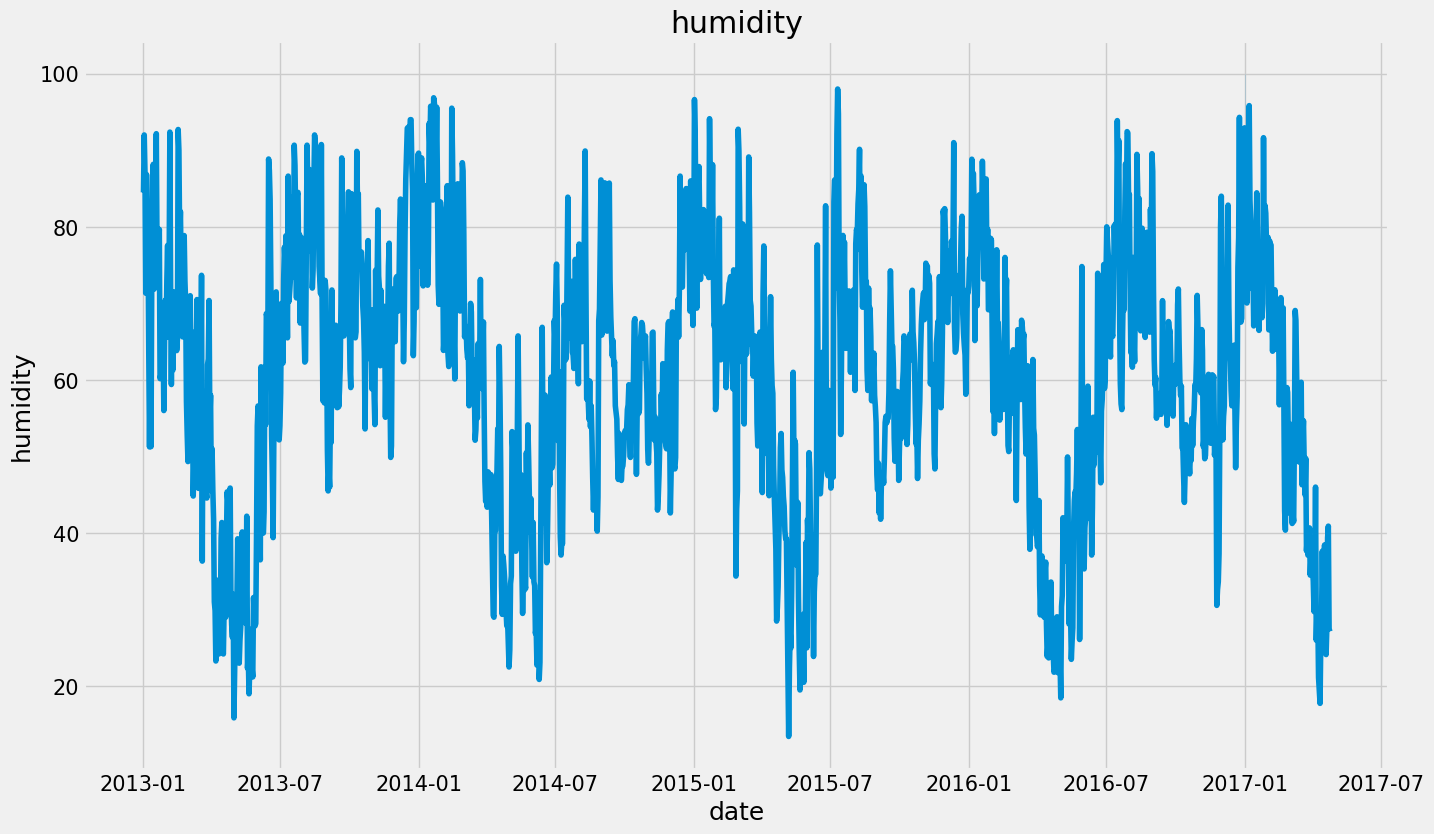

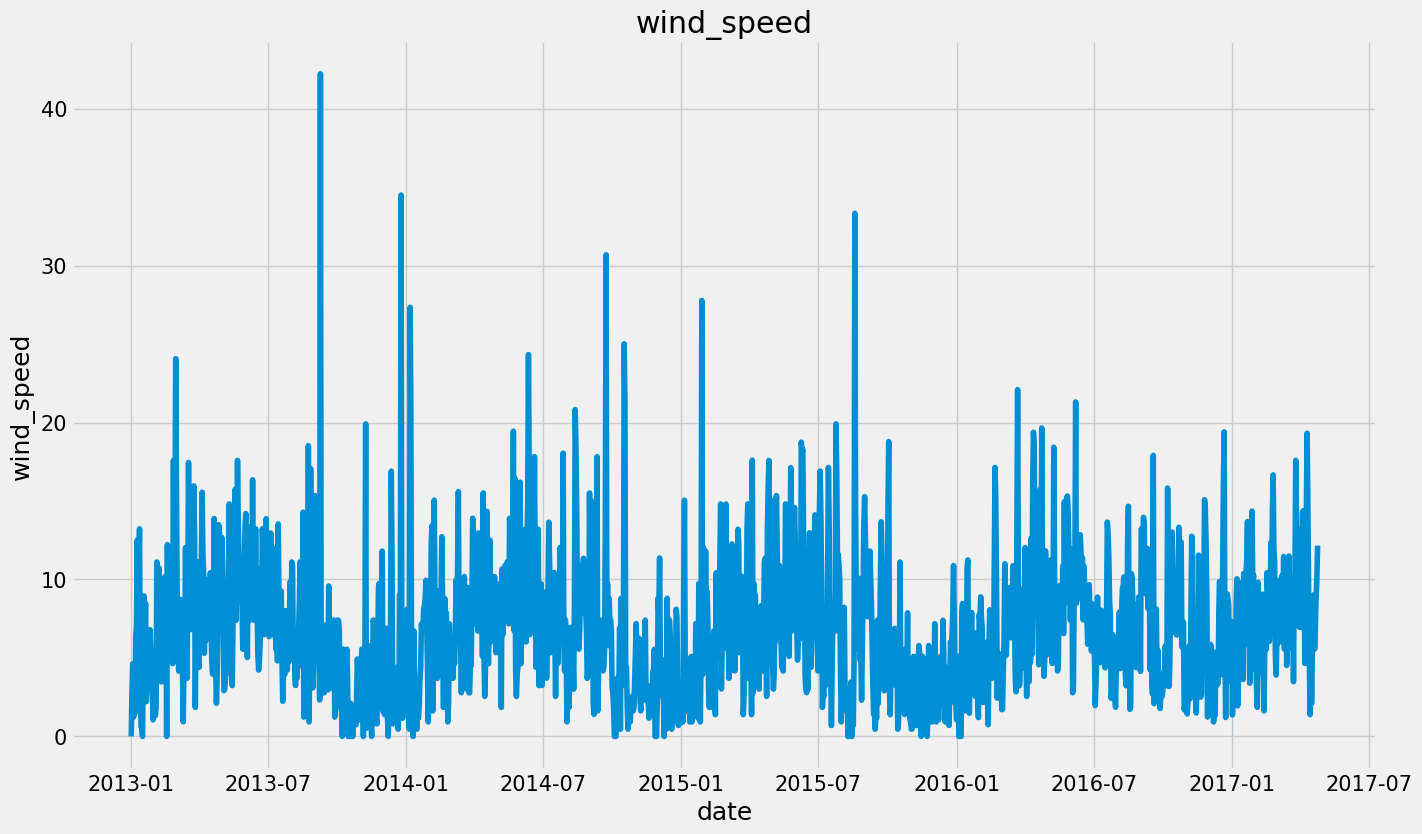

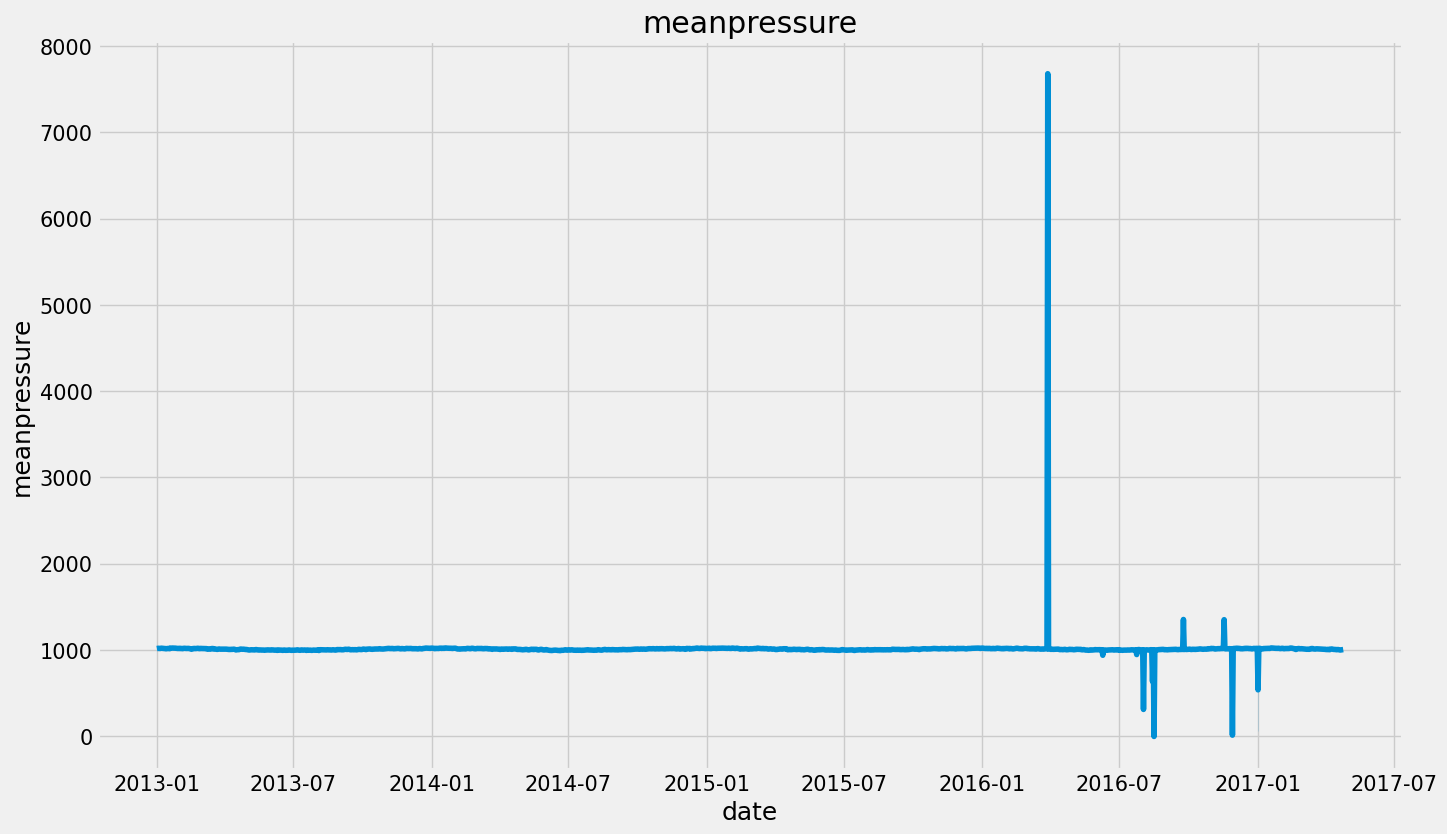

In [34]:
# Visualizing the behavior of all columns
columns = df.drop(columns=['date']).columns
for column in columns:
    sns.lineplot(x=df['date'], y=df[column])
    plt.title(column)
    plt.show()

In [35]:
# Function to convert our dataset in a time series dataset
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

In [36]:
# scale all the dataset (not including the date)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='date'))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns='date').columns)

# Set the window to 10
window = 10
feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'meantemp']

# Create a window with all the columns as features (excluding the date)
feature, target = create_window(df_scaled['meantemp'],df_scaled[feature_columns], window=window)
print(feature[0])
print(target[0])
print(df_scaled.head(12))

[[ 1.41710331 -1.53000954  0.0289604  -2.07307279]
 [ 1.85893977 -0.8691521   0.04113786 -2.42716677]
 [ 1.56438213 -0.50250189  0.04608495 -2.45894443]
 [ 0.64143486 -1.25650031  0.03752267 -2.25465945]
 [ 1.55456354 -0.70948185  0.03371722 -2.61783275]
 [ 1.31695371 -1.20179846  0.04227949 -2.48164276]
 [ 1.06952529 -0.13289483  0.05369586 -2.48164276]
 [ 0.19258512  0.05402075  0.04635677 -2.2287185 ]
 [-0.54170499  1.24204346  0.03657131 -1.52831284]
 [ 0.09159393  0.11104584  0.0289604  -1.93688281]]
[-1.29484429]
    meantemp  humidity  wind_speed  meanpressure
0  -2.073073  1.417103   -1.530010      0.028960
1  -2.427167  1.858940   -0.869152      0.041138
2  -2.458944  1.564382   -0.502502      0.046085
3  -2.254659  0.641435   -1.256500      0.037523
4  -2.617833  1.554564   -0.709482      0.033717
5  -2.481643  1.316954   -1.201798      0.042279
6  -2.481643  1.069525   -0.132895      0.053696
7  -2.228718  0.192585    0.054021      0.046357
8  -1.528313 -0.541705    1.242043

In [37]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.9):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

<Axes: xlabel='date'>

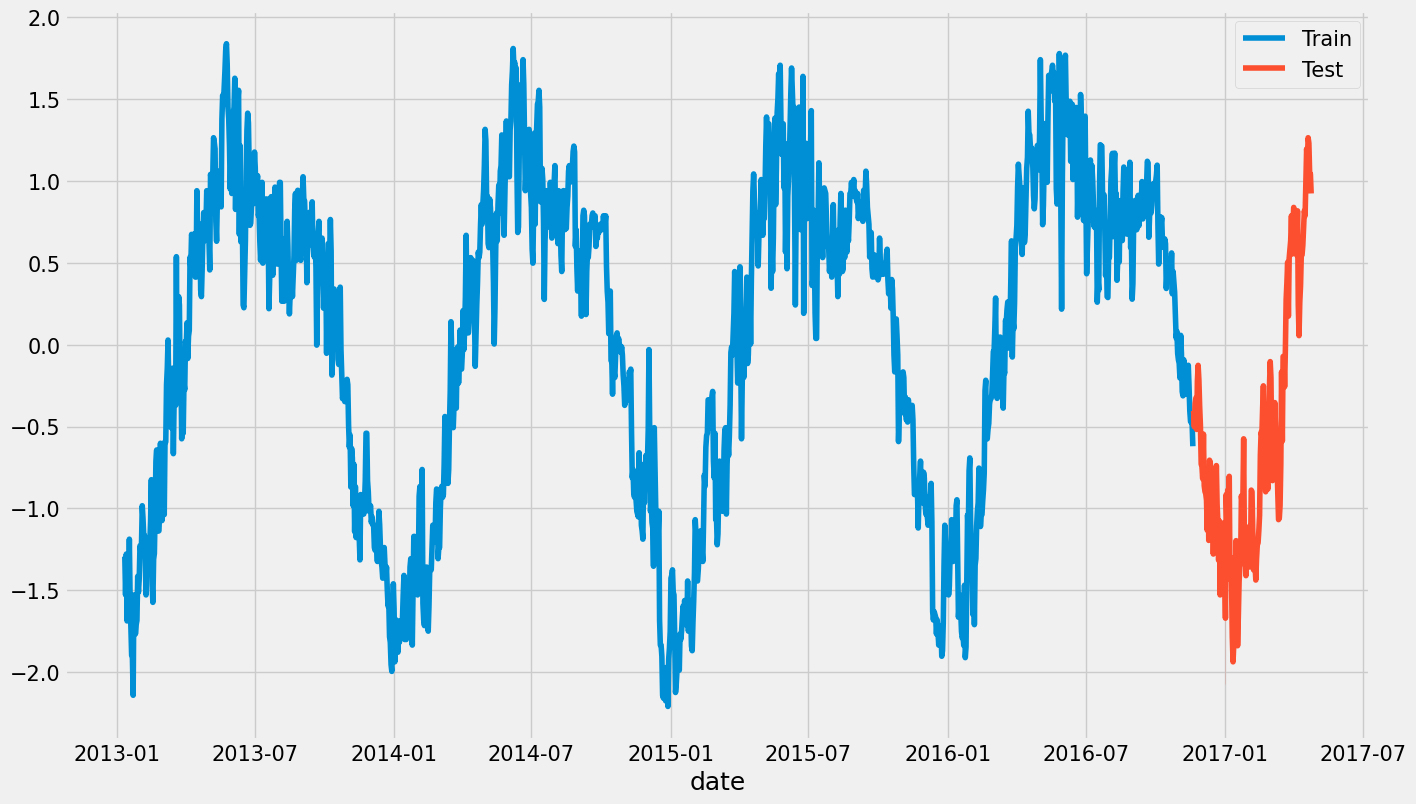

In [38]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

In [39]:
# Create a standard model using LSTM
def model_lstm(x_shape):

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=(x_shape[1], x_shape[2])))
    model.add(keras.layers.Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model

In [40]:
model = model_lstm(x_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17729 (69.25 KB)
Trainable params: 17729 (69.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
45/45 [==============================] - 3s 23ms/step - loss: 0.1688 - val_loss: 0.1366
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0802 - val_loss: 0.1495
Epoch 3/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0699 - val_loss: 0.0993
Epoch 4/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0642 - val_loss: 0.0957
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0608 - val_loss: 0.0981
Epoch 6/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0578 - val_loss: 0.1153
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0565 - val_loss: 0.0803
Epoch 8/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0547 - val_loss: 0.0769
Epoch 9/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0533 - val_loss: 0.0703
Epoch 10/50
45/45 [==============================] - 0s 11ms/step - loss: 0.0515 - val_loss: 0.0771
Epoch 11/50
45/45

In [42]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

# Function to print the y_predicted compared with the y_test
def print_test_x_prediction(y_test, y_predict, df_date, train_size, window=0):
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_test[:,0], label = 'Test')
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_predict[:,0], label = 'Predict')
    plt.show()

5/5 [==============================] - 1s 5ms/step


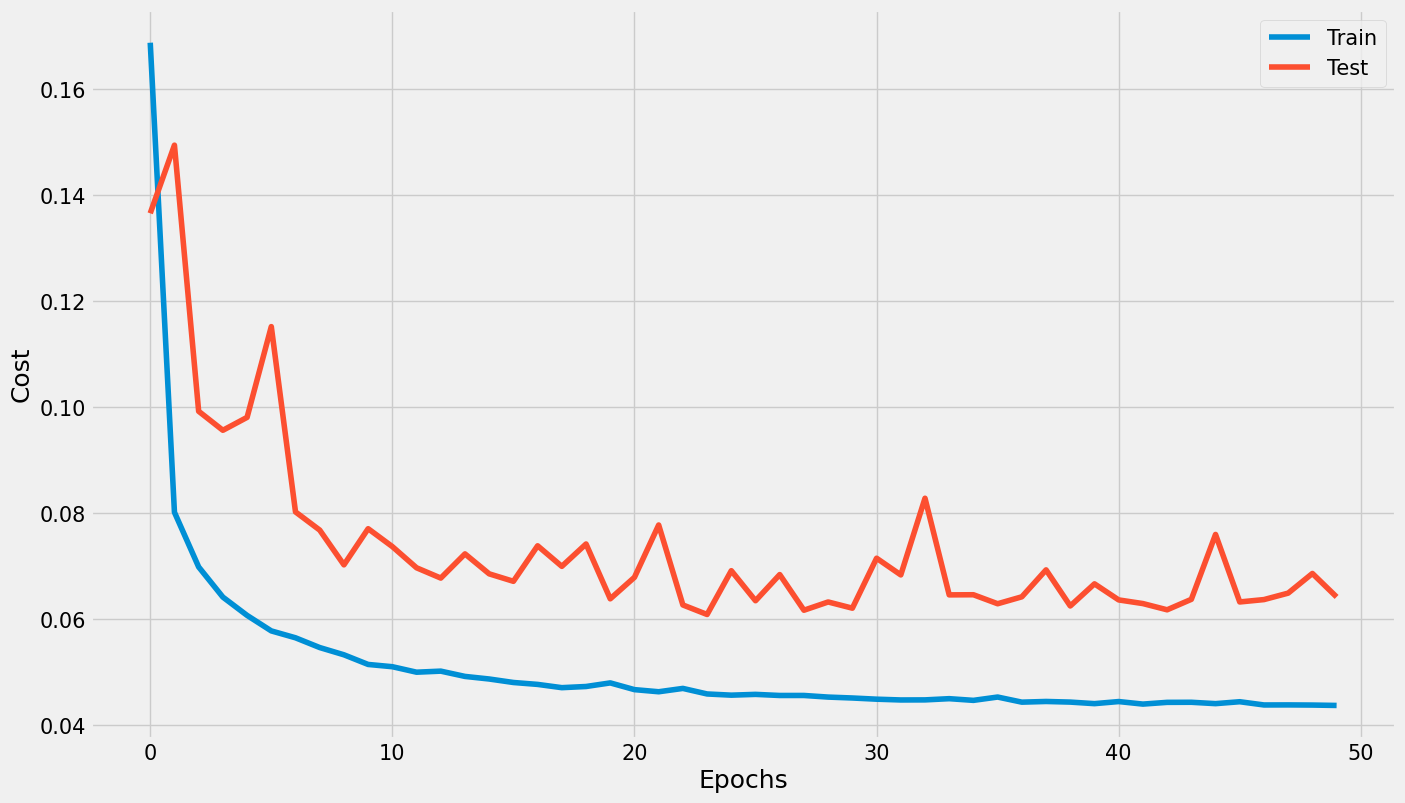

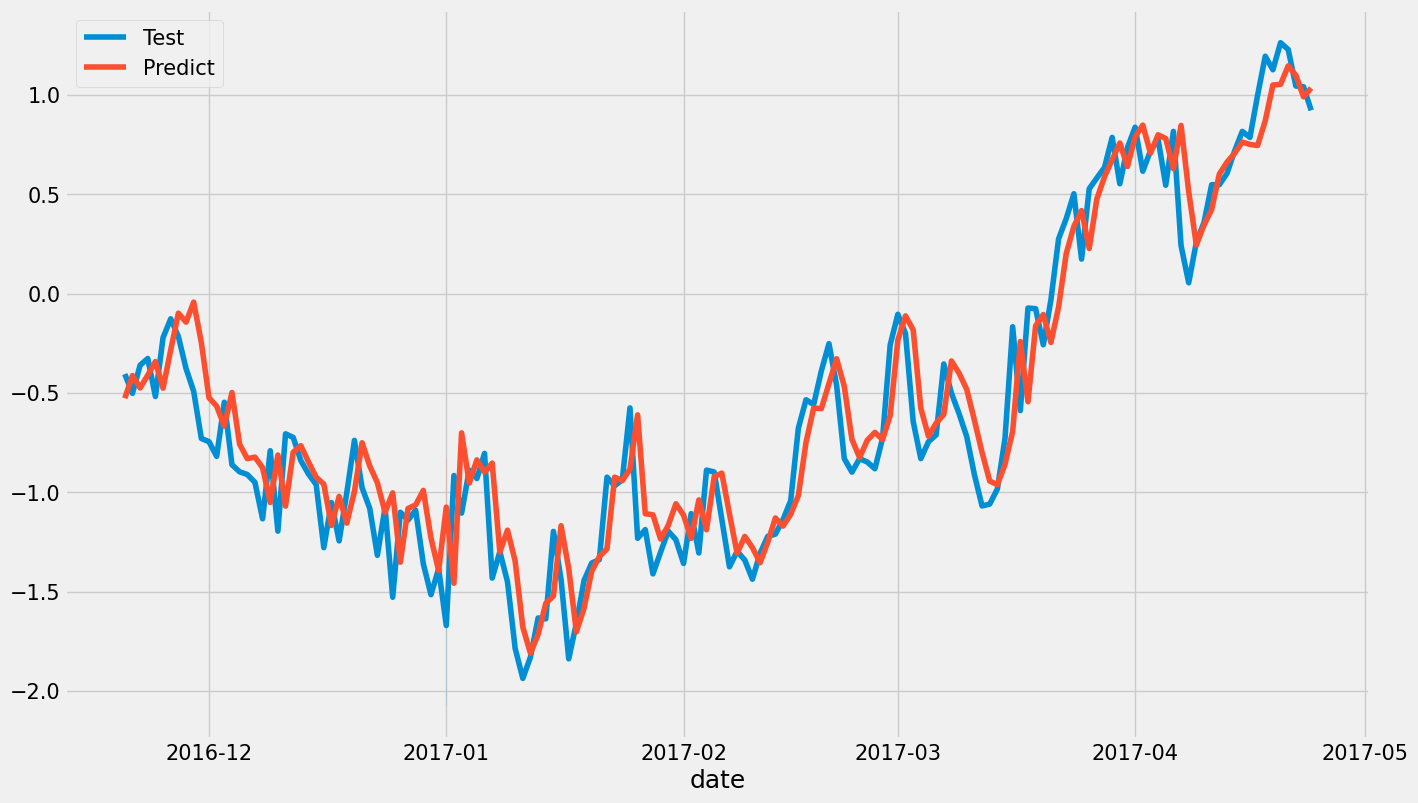

In [43]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)